In [32]:
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

In [33]:
print("Versão:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

Versão: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [34]:
img_size = (224, 224) # 224x224, tamanho que o MobileNetV2 espera
batch_size = 32       # 32 entradas por treino

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
#link (mova pro drive): https://drive.google.com/file/d/1wY1QW-8jKKDkKIadKwv54Yl-A1OXws7N/view?usp=drive_link

import zipfile
import os

zip_path = "/content/drive/MyDrive/vehicle-10.zip"
extract_path = "/content/vehicle_data"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


FileNotFoundError: [Errno 2] No such file or directory: 'https://drive.google.com/file/d/1wY1QW-8jKKDkKIadKwv54Yl-A1OXws7N/view?usp=drive_link'

In [42]:
data = "/content/vehicle_data/vehicle-10/"

# Carrega o dataset.
# 80% vai pro treino, 20% vai pro teste
train_ds = tf.keras.utils.image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Normaliza os dados pro padrão do MobileNetV2 (-1, 1)
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 20756 files belonging to 4 classes.
Using 16605 files for training.
Found 20756 files belonging to 4 classes.
Using 4151 files for validation.


In [45]:
from tensorflow.keras.optimizers import Adam

# Base MobileNetV2 pré-treinada no ImageNet.
# Em "include_top=False" a camada de saída original é removida.
base_model = MobileNetV2(input_shape=(224,224,3),
                         include_top=False,
                         weights='imagenet')

# Congela a base parcialmente (mantém os pesos pré-treinados do modelo)
base_model.trainable = False

# Adiciona camadas para classificação multi classe
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])


# Otimizador ADAM com learning rate ajustável
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Realiza o treinamento para 10 épocas
# O early_stop tenta evitar overfitting, isto é, o modelo fica "viciado" com os dados do treinamento
# E perde a capacidade de generalização
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 175s 320ms/step - accuracy: 0.8817 - loss: 0.3288 - val_accuracy: 0.9265 - val_loss: 0.2074
Epoch 2/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 150s 288ms/step - accuracy: 0.9378 - loss: 0.1717 - val_accuracy: 0.9272 - val_loss: 0.2211
Epoch 3/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 122s 235ms/step - accuracy: 0.9454 - loss: 0.1441 - val_accuracy: 0.9325 - val_loss: 0.2107
Epoch 4/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 124s 240ms/step - accuracy: 0.9575 - loss: 0.1141 - val_accuracy: 0.9321 - val_loss: 0.2195
Epoch 5/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 135s 227ms/step - accuracy: 0.9668 - loss: 0.0902 - val_accuracy: 0.9338 - val_loss: 0.2194
Epoch 6/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 118s 227ms/step - accuracy: 0.9758 - loss: 0.0704 - val_accuracy: 0.9316 - val_loss: 0.2402
Epoch 7/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 143s 228ms/step - accuracy: 0.9832 - loss: 0.0508 - val_accuracy: 0.9304 - val_loss: 0.2579
Epoch 8/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 117s 226ms/step - accuracy: 0.9848 -

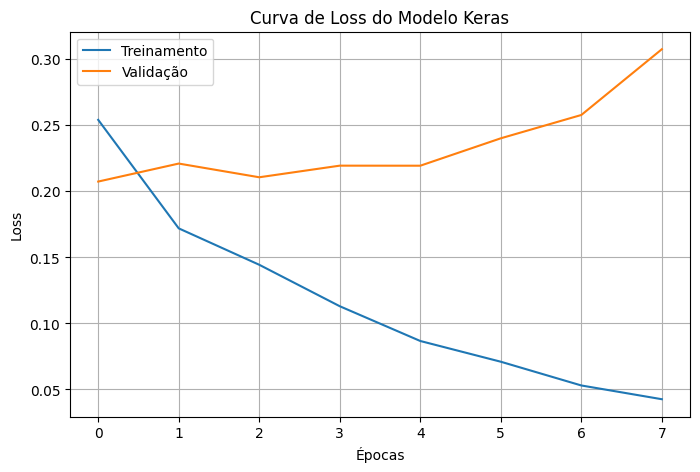

In [90]:
import matplotlib.pyplot as plt

# ----------------------------
# LOSS DO TREINAMENTO
# ----------------------------

plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Treinamento")
plt.plot(history.history["val_loss"], label="Validação")
plt.title("Curva de Loss do Modelo Keras")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

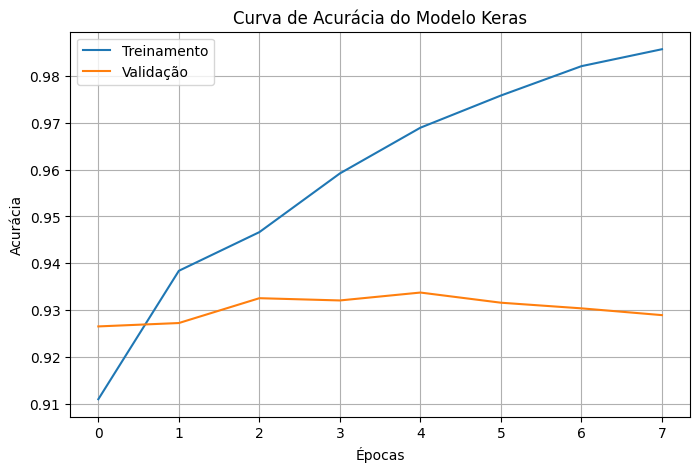

In [91]:
# ----------------------------
# ACURÁCIA DO TREINAMENTO
# ----------------------------

plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="Treinamento")
plt.plot(history.history["val_accuracy"], label="Validação")
plt.title("Curva de Acurácia do Modelo Keras")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
model.save("model.keras")

# 2) Exportar SavedModel para uso com TFLite / TF Serving
saved_model_dir = "cnn_cifar10_savedmodel"

# Se já existir, apagar para evitar conflitos
if os.path.exists(saved_model_dir):
    shutil.rmtree(saved_model_dir)

model.export(saved_model_dir)

Saved artifact at 'cnn_cifar10_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_1108')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139418409087248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409083024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409085904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409084368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409084944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409086672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409085328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409085136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409086480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409075536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139

In [52]:
converted_model_path = "model.tflite"

# Cria um conversor TFLite a partir de um modelo Keras
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Não quantiza (continua float32), mas faz otimizações internas no grafo
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Converte o modelo para TFLite
converted_model = converter.convert()

# Salva o arquivo .tflite no disco
with open( converted_model_path, "wb") as f:
    f.write(converted_model)

print("Modelo TFLite float32 salvo em:",  converted_model_path)

Saved artifact at '/tmp/tmp7u13qnxv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_1108')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139418409087248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409083024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409085904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409084368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409084944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409086672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409085328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409085136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409086480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409075536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139418409

In [89]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model("model.keras")
img_size = (224, 224)

classes = ["bus", "car", "motorcycle", "truck"]

def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize(img_size)
    img = np.array(img, dtype=np.float32)

    img = img / 255.0

    img = np.expand_dims(img, axis=0)
    return img

img_paths = [
        "/content/drive/MyDrive/test/truck.jpg",
        "/content/drive/MyDrive/test/delorean.jpg",
        "/content/drive/MyDrive/test/fusca.jpg",
        "/content/drive/MyDrive/test/moto.jpg",
        "/content/drive/MyDrive/test/buss.jpg",
        "/content/drive/MyDrive/test/onix.jpg",
        "/content/drive/MyDrive/test/1113.jpg",
        "/content/drive/MyDrive/test/skyline.jpg",
        "/content/drive/MyDrive/test/fire.jpg",
        "/content/drive/MyDrive/test/audi.jpg",
        "/content/drive/MyDrive/test/ambulance.jpg",
      ]

for img_path in img_paths:
  img = preprocess_image(img_path)

  print("Classe: ", classes[np.argmax(model.predict(img, verbose=0))], " | Predicao: ", np.round(model.predict(img, verbose=0)[0], 2))

Classe:  truck  | Predicao:  [0. 0. 0. 1.]
Classe:  car  | Predicao:  [0.   0.99 0.01 0.  ]
Classe:  car  | Predicao:  [0. 1. 0. 0.]
Classe:  motorcycle  | Predicao:  [0. 0. 1. 0.]
Classe:  bus  | Predicao:  [0.98 0.   0.   0.01]
Classe:  car  | Predicao:  [0. 1. 0. 0.]
Classe:  truck  | Predicao:  [0.   0.01 0.   0.99]
Classe:  car  | Predicao:  [0. 1. 0. 0.]
Classe:  truck  | Predicao:  [0.   0.01 0.   0.99]
Classe:  car  | Predicao:  [0. 1. 0. 0.]
Classe:  car  | Predicao:  [0.12 0.48 0.03 0.38]
